In [ ]:
# Mount Google Drive for file access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Identify available GPU in the environment
import tensorflow as tf
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))
# List all devices (CPUs and GPUs) accessible to TensorFlow
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Import InceptionV3 and preprocessing utilities from Keras applications
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import numpy as np # Import NumPy for data manipulation

In [ ]:
#Initialize InceptionV3 with ImageNet weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

87910968/87910968 [==============================] - 4s 0us/step


In [ ]:
# Import Model class and necessary layers for constructing the neural network

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Reference to the output of the base model
x = base_model.output

# Add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# Add a dense layer
x = Dense(512, activation='relu')(x)

# Add final dense layer for 4 classes with softmax activation
predictions = Dense(4, activation='softmax')(x)

# Construct the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Display the architecture of the model, including layer types and output shapes
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [ ]:
# Import data preprocessing and augmentation tools for image data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import Keras optimizers for training the model
from keras import optimizers

# Import model frameworks and layers for building neural network architectures
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D

# Import callback utility to save the model at certain checkpoints during training
from keras.callbacks import ModelCheckpoint

In [ ]:
# training and validation folder paths
train_data_dir = '/content/drive/MyDrive/ORGANOIDS_EXPERIMENTS/Final_Organoids_Dataset/train_folder'
val_data_dir = '/content/drive/MyDrive/ORGANOIDS_EXPERIMENTS/Final_Organoids_Dataset/val_folder'

In [ ]:
# Set the batch size for training and number of training epochs
batch_size = 128
num_epochs = 40

In [ ]:
# Set up an image data generator with specified augmentations for model training
data_augmentation = ImageDataGenerator(
    rotation_range=20,       # Randomly rotate images within 20 degrees
    brightness_range=[0.8, 1.2],  # Randomly adjust brightness between 80% and 120%
    width_shift_range=0.2,   # Randomly shift images horizontally by 20% of the width
    height_shift_range=0.2,  # Randomly shift images vertically by 20% of the height
    horizontal_flip=True,    # Randomly flip images horizontally
    zoom_range=0.2,          # Randomly zoom images by 20%
    fill_mode='nearest'      # Fill in new pixels created by rotation or width/height shift
)

In [ ]:
# Prepare the training data generator with augmentation, target size, batch size, and class mode
train_generator = data_augmentation.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)
# Prepare the validation data generator with augmentation, target size, batch size, and class mode
val_generator = data_augmentation.flow_from_directory(
    val_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 18537 images belonging to 4 classes.
Found 2058 images belonging to 4 classes.


In [ ]:
import time
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Set up the ModelCheckpoint callback to save only the best model based on the minimum validation loss
checkpoint_filepath = '/content/best_model.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# Set up the EarlyStopping callback for early stopping to prevent overfitting, with a patience of 10 epochs
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True
)

# Start measuring time
start_time = time.time()


# Train the model with the training data generator and apply callbacks for checkpointing and early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=num_epochs,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
    callbacks=[model_checkpoint_callback, early_stopping_callback]  # Add both callbacks to the list
)

# End measuring time
end_time = time.time()

# Calculate computational cost
computational_cost = end_time - start_time

# Print computational cost
print(f"Computational cost for model.fit: {computational_cost} seconds")

Epoch 1/40
144/144 [==============================] - ETA: 0s - loss: 0.6101 - accuracy: 0.7628  
Epoch 1: val_loss improved from inf to 1.29641, saving model to /content/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


144/144 [==============================] - 15315s 106s/step - loss: 0.6101 - accuracy: 0.7628 - val_loss: 1.2964 - val_accuracy: 0.5444
Epoch 2/40
144/144 [==============================] - ETA: 0s - loss: 0.4458 - accuracy: 0.8255
Epoch 2: val_loss improved from 1.29641 to 0.55755, saving model to /content/best_model.h5
144/144 [==============================] - 280s 2s/step - loss: 0.4458 - accuracy: 0.8255 - val_loss: 0.5575 - val_accuracy: 0.8208
Epoch 3/40
144/144 [==============================] - ETA: 0s - loss: 0.4093 - accuracy: 0.8374
Epoch 3: val_loss improved from 0.55755 to 0.46384, saving model to /content/best_model.h5
144/144 [==============================] - 280s 2s/step - loss: 0.4093 - accuracy: 0.8374 - val_loss: 0.4638 - val_accuracy: 0.8120
Epoch 4/40
144/144 [==============================] - ETA: 0s - loss: 0.3996 - accuracy: 0.8436
Epoch 4: val_loss improved from 0.46384 to 0.40759, saving model to /content/best_model.h5
144/144 [==============================

In [ ]:
# Retrieve training and validation loss and accuracy from the history object for analysis
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

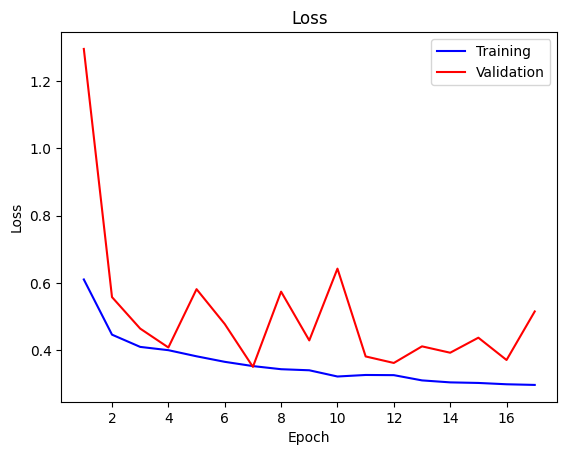

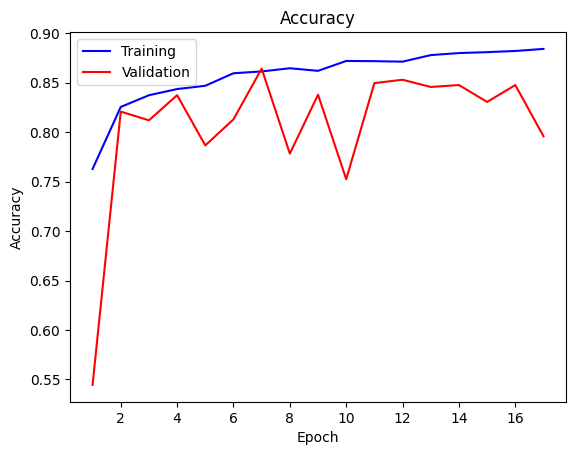

In [ ]:
import matplotlib.pyplot as plt

# Generate the range of epochs for the x-axis
epochs = range(1, len(train_loss) + 1)

# Plot and save the loss figure with 600 DPI
plt.plot(epochs, train_loss, 'b-', label='Training')
plt.plot(epochs, val_loss, 'r-', label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Save the figure in a suitable format (e.g., PNG) with 600 DPI for line drawings
plt.savefig('loss_plot_line_drawings.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

# Plot and save the accuracy figure with 600 DPI
plt.plot(epochs, train_acc, 'b-', label='Training')
plt.plot(epochs, val_acc, 'r-', label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Save the figure in a suitable format (e.g., PNG) with 600 DPI for line drawings
plt.savefig('accuracy_plot_line_drawings.png', format='png', dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
# Import the ImageDataGenerator class for data preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the directory path for test data
test_data_dir = '/content/drive/MyDrive/ORGANOIDS_EXPERIMENTS/Final_Organoids_Dataset/test_folder'

# Initialize the ImageDataGenerator without augmentation for test data evaluation
test_datagen = ImageDataGenerator()

# Prepare the test data generator with specified target size, batch size, class mode, and without shuffling
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False # Data ordering will be preserved
)

Found 2468 images belonging to 4 classes.


In [ ]:
#testing

import time
import numpy as np
from keras.models import load_model

# Load the previously trained and saved best model
model_path = '/content/best_model.h5'
model = load_model(model_path)

# Measuring the time spent on loading data and making predictions
# Start measuring time
start_time = time.time()

# Load true labels for the test set from the generator
y_true = test_generator.classes  # Actual class labels

#Generate model predictions for the test set
y_pred = model.predict(test_generator)  # Model predictions

# Determine the class predictions based on the highest probability
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted class labels

# Record the ending time for prediction and calculate the duration
end_time = time.time()

# Calculate computational cost
computational_cost = end_time - start_time

# Output the total time taken for the prediction process
print(f"Computational cost: {computational_cost} seconds")

In [ ]:
y_pred

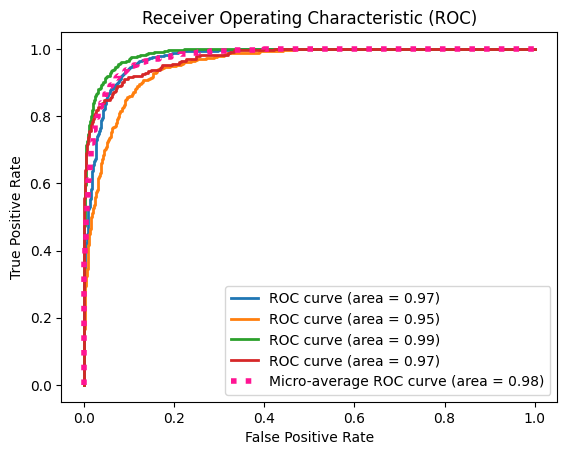

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# y_true contains true labels, and y_pred_classes contains predicted classes

# Binarize the true labels (one-hot encoding)
n_classes = len(np.unique(y_true))
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure()
lw = 2
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = %0.2f)' % roc_auc["micro"],
         color='deeppink', linestyle=':', linewidth=4)

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
# Save the figure in a suitable format (e.g., PNG) with 600 DPI for line drawings
plt.savefig('roc_curves.png', format='png', dpi=600, bbox_inches='tight')
plt.show()


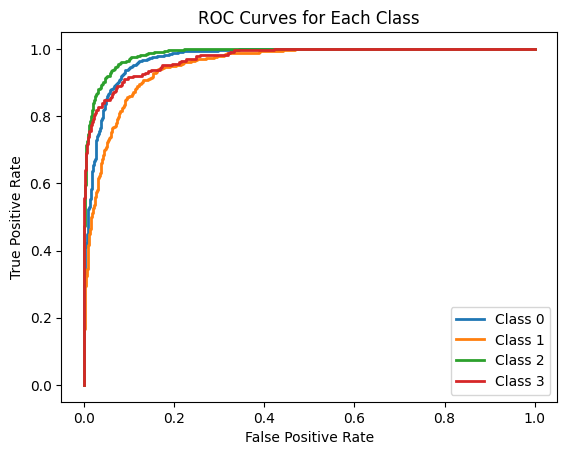

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# y_true contains true labels, and y_pred contains predicted probabilities

# Binarize the true labels (one-hot encoding)
n_classes = 4  # Number of classes (change to your actual number of classes)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Initialize dictionaries to store FPR and TPR for each class
fpr_dict = {}
tpr_dict = {}

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])

# Plot ROC curves for each class
plt.figure()
lw = 2
for i in range(n_classes):
    plt.plot(fpr_dict[i], tpr_dict[i], lw=lw, label=f'Class {i}')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.savefig('roc_curves_for_class.png', format='png', dpi=600, bbox_inches='tight')

# Show the plot
plt.show()

# Save FPR and TPR values to separate CSV files for each class
for i in range(n_classes):
    class_name = f'Class_{i}'
    fpr = fpr_dict[i]
    tpr = tpr_dict[i]

    # Save FPR and TPR values for the class to a CSV file
    with open(f'{class_name}_roc_curve.csv', 'w') as file:
        file.write('False Positive Rate, True Positive Rate\n')
        for j in range(len(fpr)):
            file.write(f'{fpr[j]}, {tpr[j]}\n')


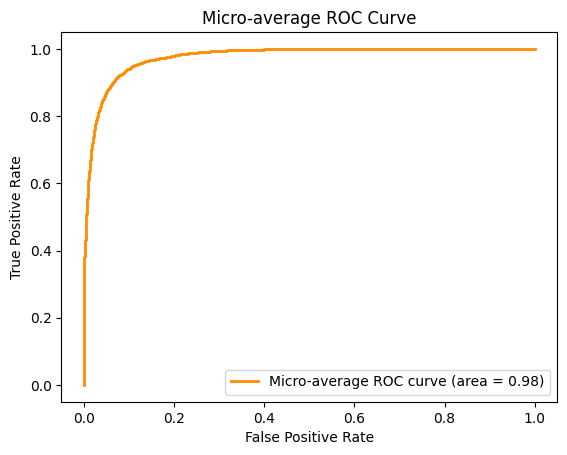

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# y_true contains true labels, and y_pred contains predicted probabilities

# Binarize the true labels (one-hot encoding)
n_classes = 4  # Number of classes (change to your actual number of classes)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot the micro-average ROC curve
plt.figure()
lw = 2
plt.plot(fpr_micro, tpr_micro, color='darkorange',
         lw=lw, label=f'Micro-average ROC curve (area = {roc_auc_micro:.2f})')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve')
plt.legend(loc="lower right")
plt.savefig('micro_avg_roc_curves.png', format='png', dpi=600, bbox_inches='tight')


# Show the plot
plt.show()

import pandas as pd

# Create a dataframe with fpr_micro and tpr_micro
df = pd.DataFrame({'fpr_micro': fpr_micro, 'tpr_micro': tpr_micro})

# Save the dataframe to a CSV file
df.to_csv('fpr_tpr_micro_values.csv', index=False)


In [ ]:
# Import classification metrics and confusion matrix functions from scikit-learn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate the main classification metrics to evaluate the model's performance
accuracy = accuracy_score(y_true, y_pred_classes) # Overall accuracy of model predictions
precision = precision_score(y_true, y_pred_classes, average='weighted') # Precision score considering class imbalance
recall = recall_score(y_true, y_pred_classes, average='weighted') # Recall score considering class imbalance
f1 = f1_score(y_true, y_pred_classes, average='weighted') # Harmonic mean of precision and recall

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.8610210696920584
Precision: 0.8667327781022002
Recall: 0.8610210696920584
F1-score: 0.8628558231783477


In [ ]:
# Calculate overall accuracy and the 'macro' average (unweighted mean across classes) for precision, recall, and F1 score
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
f1 = f1_score(y_true, y_pred_classes, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.8610210696920584
Precision: 0.8338755701788318
Recall: 0.8392316263497253
F1-score: 0.8355607350399183


In [ ]:
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
print("Matrice di confusione:")
print(confusion_mtx)

Matrice di confusione:
[[1152  102    0   40]
 [  38  456   48    6]
 [   1   60  340    0]
 [  43    5    0  177]]


In [ ]:
# Save the confusion matrix values to a text file (e.g., CSV)
with open('confusion_matrix.csv', 'w') as file:
    file.write("Confusion Matrix:\n")
    for row in confusion_mtx:
        file.write(','.join(map(str, row)) + '\n')

Confusion Matrix:
[[1152  102    0   40]
 [  38  456   48    6]
 [   1   60  340    0]
 [  43    5    0  177]]


In [ ]:
# Import NumPy for numerical operations and scikit-learn's roc_curve function for ROC curve analysis
import numpy as np
from sklearn.metrics import roc_curve

# y_true contains true labels, and y_pred contains predicted probabilities

# Binarize the true labels (one-hot encoding)
n_classes = 4  # Number of classes (change to your actual number of classes)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Initialize dictionaries to store FPR and TPR for each class
fpr_dict = {}
tpr_dict = {}

# Compute ROC curve for each class
for i in range(n_classes):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])

# Print TPR and FPR for each class
for i in range(n_classes):
    print(f"Class {i}:")
    print(f"TPR (True Positive Rate): {tpr_dict[i]}")
    print(f"FPR (False Positive Rate): {fpr_dict[i]}")
    print()


Class 0:
TPR (True Positive Rate): [0.00000000e+00 7.72797527e-04 2.06336940e-01 2.06336940e-01
 2.97527048e-01 2.97527048e-01 3.73261206e-01 3.73261206e-01
 4.02627512e-01 4.02627512e-01 4.09582689e-01 4.09582689e-01
 4.12673879e-01 4.12673879e-01 4.21947450e-01 4.21947450e-01
 4.31993818e-01 4.31993818e-01 4.46676971e-01 4.46676971e-01
 4.48995363e-01 4.48995363e-01 4.54404946e-01 4.54404946e-01
 4.61360124e-01 4.61360124e-01 5.23956723e-01 5.23956723e-01
 5.29366306e-01 5.29366306e-01 5.30139104e-01 5.30139104e-01
 5.31684699e-01 5.31684699e-01 5.41731066e-01 5.41731066e-01
 5.54095827e-01 5.54095827e-01 5.83462133e-01 5.83462133e-01
 5.98918083e-01 5.98918083e-01 6.24420402e-01 6.24420402e-01
 6.35239567e-01 6.35239567e-01 6.39103555e-01 6.39103555e-01
 6.45285935e-01 6.45285935e-01 6.54559505e-01 6.54559505e-01
 6.62287481e-01 6.62287481e-01 6.67697063e-01 6.67697063e-01
 6.72333849e-01 6.72333849e-01 6.73106646e-01 6.73106646e-01
 6.92426584e-01 6.92426584e-01 7.30293663e-01 7.30

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# y_true contains true labels, and y_pred_classes contains predicted classes

# Calculate confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Calculate classification report
classification_rep = classification_report(y_true, y_pred_classes)

# Calculate overall accuracy
accuracy = np.mean(y_true == y_pred_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_mtx)

# Print classification report
print("\nClassification Report:")
print(classification_rep)

# Print overall accuracy
print(f"\nOverall Accuracy: {accuracy:.2%}")


Confusion Matrix:
[[1152  102    0   40]
 [  38  456   48    6]
 [   1   60  340    0]
 [  43    5    0  177]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1294
           1       0.73      0.83      0.78       548
           2       0.88      0.85      0.86       401
           3       0.79      0.79      0.79       225

    accuracy                           0.86      2468
   macro avg       0.83      0.84      0.84      2468
weighted avg       0.87      0.86      0.86      2468


Overall Accuracy: 86.10%


In [ ]:
from sklearn.metrics import confusion_matrix

# y_true contains true labels, and y_pred_classes contains predicted classes

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Calculate sensitivity (TPR) and specificity for each class
sensitivity = []
specificity = []

for i in range(len(confusion_mtx)):
    true_positives = confusion_mtx[i, i]
    false_negatives = np.sum(confusion_mtx[i, :]) - true_positives
    true_negatives = np.sum(confusion_mtx) - np.sum(confusion_mtx[i, :]) - np.sum(confusion_mtx[:, i]) + true_positives
    false_positives = np.sum(confusion_mtx[:, i]) - true_positives

    sensitivity_i = true_positives / (true_positives + false_negatives)
    specificity_i = true_negatives / (true_negatives + false_positives)

    sensitivity.append(sensitivity_i)
    specificity.append(specificity_i)

# Print sensitivity and specificity for each class
for i in range(len(sensitivity)):
    print(f"Class {i}:")
    print(f"Sensitivity (True Positive Rate): {sensitivity[i]:.2f}")
    print(f"Specificity (True Negative Rate): {specificity[i]:.2f}")
    print()


Class 0:
Sensitivity (True Positive Rate): 0.89
Specificity (True Negative Rate): 0.93

Class 1:
Sensitivity (True Positive Rate): 0.83
Specificity (True Negative Rate): 0.91

Class 2:
Sensitivity (True Positive Rate): 0.85
Specificity (True Negative Rate): 0.98

Class 3:
Sensitivity (True Positive Rate): 0.79
Specificity (True Negative Rate): 0.98



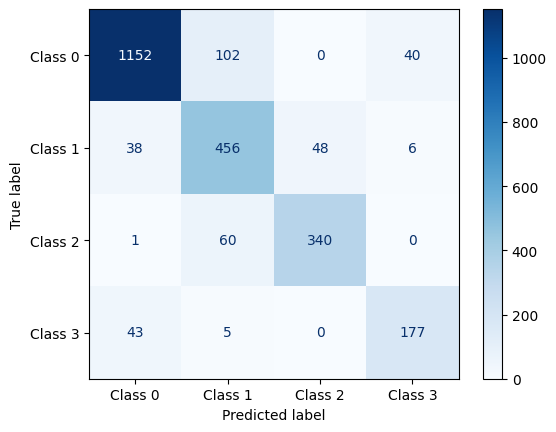

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


# Display labels for the classes
display_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3']

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=display_labels)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)

# Save the figure as a PNG file
plt.savefig('cm_conf_4_classes.png', dpi=100)

# Show the plot
plt.show()


In [ ]:
confusion_mtx

array([[1152,  102,    0,   40],
       [  38,  456,   48,    6],
       [   1,   60,  340,    0],
       [  43,    5,    0,  177]])

In [ ]:
import numpy as np

def print_confusion_matrix(matrix):
    print("Confusion Matrix:")
    print("array(", end='')
    for i, row in enumerate(matrix):
        if i == 0:
            print("[", end='')
        else:
            print("       [", end='')

        for j, value in enumerate(row):
            end_char = ", " if j < len(row) - 1 else "]"
            print(f"{value:>4}", end=end_char)

        if i < len(matrix) - 1:
            print(",")
        else:
            print("])")

# Test
matrix =confusion_mtx
print_confusion_matrix(matrix)


Confusion Matrix:
array([1152,  102,    0,   40],
       [  38,  456,   48,    6],
       [   1,   60,  340,    0],
       [  43,    5,    0,  177]])


In [ ]:
import numpy as np

def compute_metrics(matrix):
    num_classes = matrix.shape[0]

    # True positives
    TP = np.diag(matrix)

    # False positives
    FP = matrix.sum(axis=0) - TP

    # False negatives
    FN = matrix.sum(axis=1) - TP

    # True negatives
    TN = matrix.sum() - (FP + FN + TP)

    # Accuracy
    overall_accuracy = TP.sum() / matrix.sum()

    # Sensitivity/Recall
    sensitivity = TP / (TP + FN)

    # Specificity
    specificity = TN / (TN + FP)

    # Precision
    precision = TP / (TP + FP)

    # F1 Score
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)

    return overall_accuracy, sensitivity, specificity, f1_score

# Test
matrix = confusion_mtx
overall_accuracy, sensitivity, specificity, f1_score = compute_metrics(matrix)

print(f"Overall Accuracy: {overall_accuracy:.4f}")
for i in range(matrix.shape[0]):
    print(f"\nClass {i} metrics:")
    print(f"Sensitivity/Recall: {sensitivity[i]:.4f}")
    print(f"Specificity: {specificity[i]:.4f}")
    print(f"F1 Score: {f1_score[i]:.4f}")


Overall Accuracy: 0.8610

Class 0 metrics:
Sensitivity/Recall: 0.8903
Specificity: 0.9302
F1 Score: 0.9114

Class 1 metrics:
Sensitivity/Recall: 0.8321
Specificity: 0.9130
F1 Score: 0.7788

Class 2 metrics:
Sensitivity/Recall: 0.8479
Specificity: 0.9768
F1 Score: 0.8619

Class 3 metrics:
Sensitivity/Recall: 0.7867
Specificity: 0.9795
F1 Score: 0.7902


In [ ]:
import numpy as np

def compute_metrics(matrix):
    num_classes = matrix.shape[0]

    # True positives
    TP = np.diag(matrix)

    # False positives
    FP = matrix.sum(axis=0) - TP

    # False negatives
    FN = matrix.sum(axis=1) - TP

    # True negatives
    TN = matrix.sum() - (FP + FN + TP)

    # Accuracy
    overall_accuracy = TP.sum() / matrix.sum()

    # Micro-average Sensitivity/Recall
    micro_recall = TP.sum() / (TP.sum() + FN.sum())

    # Micro-average Precision
    micro_precision = TP.sum() / (TP.sum() + FP.sum())

    # Micro-average F1 Score
    micro_f1_score = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)

    # Micro-average Specificity
    micro_specificity = TN.sum() / (TN.sum() + FP.sum())

    return overall_accuracy, micro_recall, micro_specificity, micro_f1_score

# Test
matrix = confusion_mtx

overall_accuracy, micro_recall, micro_specificity, micro_f1_score = compute_metrics(matrix)

print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Micro-average Sensitivity/Recall: {micro_recall:.4f}")
print(f"Micro-average Specificity: {micro_specificity:.4f}")
print(f"Micro-average F1 Score: {micro_f1_score:.4f}")


Overall Accuracy: 0.8610
Micro-average Sensitivity/Recall: 0.8610
Micro-average Specificity: 0.9537
Micro-average F1 Score: 0.8610


In [ ]:
y_pred

array([[9.9603432e-01, 2.7741543e-03, 2.0489510e-05, 1.1710286e-03],
       [9.7470367e-01, 3.3875392e-03, 3.7509497e-05, 2.1871328e-02],
       [9.7444439e-01, 9.5553398e-03, 2.0139012e-04, 1.5798867e-02],
       ...,
       [8.8252711e-01, 8.2450517e-02, 2.5384087e-04, 3.4768559e-02],
       [7.6122761e-01, 2.2558106e-02, 5.1122927e-04, 2.1570307e-01],
       [8.4726465e-01, 2.9167165e-03, 9.7196629e-05, 1.4972144e-01]],
      dtype=float32)

In [ ]:
y_true

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [ ]:
# Select the index of the class with the highest probability for each example
predicted_classes = np.argmax(y_pred, axis=1)

# Create a DataFrame with the predicted classes
df_predictions = pd.DataFrame(predicted_classes, columns=['Predicted Class'])

# Save the DataFrame to an Excel file
df_predictions.to_excel('test_predictions_InceptionV3.xlsx', index=False)
